<a href="https://colab.research.google.com/github/JoeEbbyKaruthedath/JoeEbbyKaruthedath/blob/main/Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.datasets import load_iris # Import Iris Data Set
from sklearn.linear_model import LogisticRegression 
import numpy as np                     # NumPy is the package for scientific computing with Python
from sklearn.model_selection import learning_curve 
# Determines cross-validated training and test scores for different training set sizes

# Random permutation cross-validator
from sklearn.model_selection import ShuffleSplit
# Logistic regression classifier class
from sklearn.linear_model import LogisticRegression
# kNN classifier class
from sklearn import neighbors
# Each pyplot function makes some change to a figure: e.g., creates a figure, creates a plotting area in a figure, 
# plots some lines in a plotting area, decorates the plot with labels, etc
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score #http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.tree import DecisionTreeClassifier # A decision tree classifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', sep=',', header=None)

In [ ]:
col_names = ['id','diagnosis']
cols = ['radius',
'texture',
'perimeter',
'area',
'smoothness',
'compactness',
'concavity',
'concave_points',
'symmetry',
'fractal_dimension']*3



for i in range(0,30):
	if i < 10:
	    cols[i] += '_mean'
	elif i < 20:
	    cols[i] += '_std'
	else:
	    cols[i] += '_largest'
cols

cols = col_names + cols

df.columns = cols

In [ ]:
X, y = df[df.columns[2:]], df.diagnosis

In [ ]:
le = LabelEncoder()
#print(y)               #See label before transformation
y = le.fit_transform(y) #Labels 'M' as 1 and 'B' as 0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [ ]:
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
cv

ShuffleSplit(n_splits=10, random_state=42, test_size=0.3, train_size=None)

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)): #klinspace returns evenly spaced numbers over a specified interval (start, stop, num)

    plt.figure()                    #display figure
    plt.title(title)
    if ylim is not None:            #if ylim was specified as an input, make sure the plots use these limits
        plt.ylim(*ylim)
    plt.xlabel("Training examples") #y label title
    plt.ylabel("Score")             #x label title
    
    # Class learning_curve determines cross-validated training and test scores for different training set sizes
    # Detailed documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    # Cross validation statistics for training and testing data (mean and standard deviation)
    train_scores_mean = np.mean(train_scores, axis=1) # Compute the arithmetic mean along the specified axis.
    train_scores_std = np.std(train_scores, axis=1)   # Compute the standard deviation along the specified axis.
    test_scores_mean = np.mean(test_scores, axis=1)   # Compute the arithmetic mean along the specified axis.
    test_scores_std = np.std(test_scores, axis=1)     # Compute the standard deviation along the specified axis.

    plt.grid() # Configure the grid lines

    # Fill the area around the line to indicate the size of standard deviations for the training data
    # and the test data
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r") # train data performance indicated with red
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g") # test data performance indicated with green
    
    # Cross-validation means indicated by dots
    # Train data performance indicated with red
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    # Test data performance indicated with green
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best") # Show legend of the plot at the best location possible
    return plt             # Function that returns the plot as an output

# Decision Tree

In [ ]:
np.random.seed(42) # Ensure reproducability

inner_cv = KFold(n_splits=5, shuffle=True, random_state = 42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state = 42)

# Choosing optimal depth of the tree
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                  param_grid={'max_depth': range(1, 20),
                              'criterion': ['gini','entropy'],
                              'min_samples_leaf': np.arange(0.01, .5, .05),                                                    
                              
                                                                                                                                
                              'min_samples_split': np.arange(0.01, 1, .05)                                                      
                              #'min_samples_split' : [0]
                             },
                  scoring='f1', # Specifying multiple metrics for evaluation
                  cv=inner_cv,
                 n_jobs = -1,
                 verbose = 1)
gs.fit(X, y)


print(" Parameter Tuning #1")
print("Non-nested CV F1 Score: ", gs.best_score_)
print("Optimal Parameter: ", gs.best_params_)    # Parameter setting that gave the best results on the hold out data.
print("Optimal Estimator: ", gs.best_estimator_) # Estimator that was chosen by the search, i.e. estimator which gave highest score
nested_score_gs = cross_val_score(gs, X=X, y=y, cv=outer_cv)
print("Nested CV F1",nested_score_gs.mean(), " +/- ", nested_score_gs.std())

In [ ]:
#debug
result_list = list(zip(gs.cv_results_['split0_test_score'], gs.cv_results_['params']))
for score, params in result_list:
    if np.isnan(score): print(score, params)

# KNN

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('knn', KNeighborsClassifier(p=2, metric='minkowski'))
])

gs_knn = GridSearchCV(estimator = pipe, 
                      param_grid = {
                          'knn__n_neighbors': np.arange(1, 50, 1),
                          'knn__weights': ['distance','uniform']
                      },
                      scoring = 'f1',
                      cv = inner_cv
                     )

gs_knn.fit(X, y)
print(" Parameter Tuning #2")
print("Non-nested CV F1: ", gs_knn.best_score_)
print("Optimal Parameter: ", gs_knn.best_params_)    # Parameter setting that gave the best results on the hold out data.
print("Optimal Estimator: ", gs_knn.best_estimator_) # Estimator that was chosen by the search, i.e. estimator which gave highest score
nested_score_gs = cross_val_score(gs_knn, X=X, y=y, cv=outer_cv)
print("Nested CV F1: ",nested_score_gs.mean(), " +/- ", nested_score_gs.std())

 Parameter Tuning #2
Non-nested CV F1:  0.9523682840047905
Optimal Parameter:  {'knn__n_neighbors': 9, 'knn__weights': 'distance'}
Optimal Estimator:  Pipeline(memory=None,
         steps=[('sc',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=9, p=2,
                                      weights='distance'))],
         verbose=False)
Nested CV F1:  0.942907926140783  +/-  0.029192003323564676


# Logit

In [ ]:

gs_lg = GridSearchCV(
    estimator = LogisticRegression(random_state = 42, solver = 'liblinear', max_iter = 1000),
    param_grid = {
        'C': float(10)**(np.arange(-10, 11, 1)),
        'penalty': ['l1','l2']
        
    },
    scoring = 'f1',
    n_jobs = -1,
    cv = inner_cv
)

gs_lg.fit(X, y)
print(" Parameter Tuning #3")
print("Non-nested CV F1: ", gs_lg.best_score_)
print("Optimal Parameter: ", gs_lg.best_params_)    # Parameter setting that gave the best results on the hold out data.
print("Optimal Estimator: ", gs_lg.best_estimator_) # Estimator that was chosen by the search, i.e. estimator which gave highest score
nested_score_gs = cross_val_score(gs_lg, X=X, y=y, cv=outer_cv)
print("Nested CV F1: ",nested_score_gs.mean(), " +/- ", nested_score_gs.std())

 Parameter Tuning #3
Non-nested CV F1:  0.9600196446627185
Optimal Parameter:  {'C': 100.0, 'penalty': 'l1'}
Optimal Estimator:  LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Nested CV F1:  0.9474113726172749  +/-  0.018884437199457583


# Question B

In [ ]:
lg_clf = gs_lg.best_estimator_
cv = ShuffleSplit(n_splits = 10, test_size=0.3, random_state = 42)

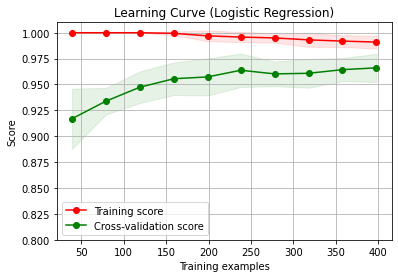

In [ ]:
plot_learning_curve(lg_clf, title = 'Learning Curve (Logistic Regression)', 
                    X = X, y = y, ylim = (0.8, 1.01), cv = cv, n_jobs = -1, train_sizes = np.linspace(0.1, 1, 10))
plt.show()

# Question C

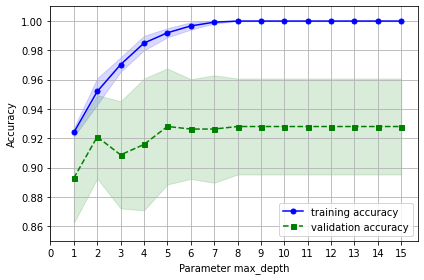

In [ ]:

# Fitting curve (aka validation curve)
# Determine training and test scores for varying parameter values.
from sklearn.model_selection import validation_curve
# Split validation
from sklearn.model_selection import train_test_split
np.random.seed(42) #the seed used by the random number generator for np

param_range = np.arange(1, 16, 1)

train_scores, test_scores = validation_curve( 
                estimator=DecisionTreeClassifier(random_state=42), #Build Logistic Regression Models
                X=X, 
                y=y, 
                param_name="max_depth",
                param_range=param_range,
                cv=10,     #10-fold cross-validation
                scoring="accuracy", 
                n_jobs=-1) # Number of CPU cores used when parallelizing over classes if multi_class=’ovr’”. This parameter is ignored when the ``solver``is set to ‘liblinear’ regardless of whether ‘multi_class’ is specified or not. If given a value of -1, all cores are used.


# Cross validation statistics for training and testing data (mean and standard deviation)
train_mean = np.mean(train_scores, axis=1) # Compute the arithmetic mean along the specified axis.
train_std = np.std(train_scores, axis=1)   # Compute the standard deviation along the specified axis.
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

############################## Visualization - Fitting Graph ##############################

# Plot train accuracy means of cross-validation for all the parameters C in param_range
plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')
# Fill the area around the line to indicate the size of standard deviations of performance for the training data
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')
# Plot test accuracy means of cross-validation for all the parameters C in param_range
plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')
# Fill the area around the line to indicate the size of standard deviations of performance for the test data
plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')
# Grid and Axes Titles
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Parameter max_depth')
plt.xticks(np.arange(0, 16, step=1))
plt.ylabel('Accuracy')
plt.ylim([0.85, 1.01]) # y limits in the plot
plt.tight_layout()
# plt.savefig('Fitting_graph_LR.png', dpi=300)
plt.show()           # Display the figure



# Question D

In [ ]:
dt_clf = gs.best_estimator_
knn_clf = gs_knn.best_estimator_
lg_clf = gs_lg.best_estimator_

In [ ]:
X_std = StandardScaler().fit_transform(X)
X_train_std, X_test_std, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state = 42)

10-fold cross validation:

ROC AUC: 0.99 (+/- 0.01) [Logistic regression]
ROC AUC: 0.96 (+/- 0.03) [Decision tree]
ROC AUC: 0.99 (+/- 0.01) [kNN]


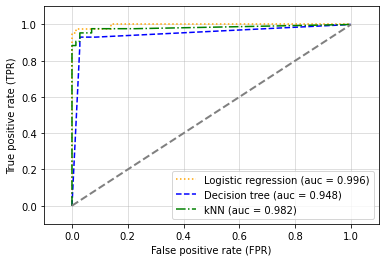

In [ ]:
############################### Import Libraries & Modules #################################

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

######################################## Classifiers ########################################

clf_labels = ['Logistic regression', 'Decision tree', 'kNN']
all_clf = [lg_clf, dt_clf, knn_clf]

#################################### Cross - Validation ####################################


print('10-fold cross validation:\n')
# Note: We are assuming here that the data is standardized. For the homework, you need to make sure the data is standardized.
for clf, label in zip(all_clf, clf_labels): #For all classifiers 
    scores = cross_val_score(estimator=clf,  #Estimate AUC based on cross validation
                             X=X,
                             y=y,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" #Print peformance statistics based on cross-validation
          % (scores.mean(), scores.std(), label))

##################################### Visualization ######################################

colors = [ 'orange', 'blue', 'green']      # Colors for visualization
linestyles = [':', '--', '-.', '-']        # Line styles for visualization
for clf, label, clr, ls in zip(all_clf,
               clf_labels, colors, linestyles):

    # Assuming the label of the positive class is 1 and data is normalized
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1] # Make predictions based on the classifiers
    fpr, tpr, thresholds = roc_curve(y_true=y_test, # Build ROC curve
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)                # Compute Area Under the Curve (AUC) 
    plt.plot(fpr, tpr,                         # Plot ROC Curve and create label with AUC values
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.3f)' % (label, roc_auc))

plt.legend(loc='lower right')    # Where to place the legend
plt.plot([0, 1], [0, 1], # Visualize random classifier
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])   #limits for x axis
plt.ylim([-0.1, 1.1])   #limits for y axis
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('ROC_all_classifiers', dpi=300)
plt.show()